# 📐 Product Dimension Estimation Using E-commerce Images

## 🎯 Project Objective

The purpose of this research is to answer the following question:

**➡️ Can the dimensions of products be estimated solely by taking pictures from different angles?**

Since there is no data available from a device like a Ridar (distance-measuring sensor), I am conducting this study using images of more than **25,000 products**. These images come from the review sections of selected products on an e-commerce site, consisting of **511 different products**, with an average of **60 images per product**.

My aim is quite challenging, but I chose to pursue this as an experimental research study.

---

## 🛠️ Data Collection & Preparation

- First, I scraped the product images from **Trendyol**.
- After scraping, I applied various **object detection models** to the images.
- I selected the best-performing object detection method.
- For each detected object, I saved details such as:
  - The area it covered in the real image,
  - The confidence score,
  - And other relevant metadata in a **CSV file**.

---

## 🤖 Model Development

- I used **pre-trained models** to fine-tune and build new models for predicting the **height and width** of products.
- I experimented with multiple approaches and selected the **most successful model** based on performance.

---

## 📝 Final Notes

This notebook presents a step-by-step approach for data collection, preprocessing, model training, and evaluation. The main goal is not necessarily to achieve high accuracy but to explore the feasibility of **estimating real-world product dimensions using only images.**

---

## 🔗 Additional Resources

If you want to see the scraping codes or more technical details, feel free to visit my GitHub:

[![GitHub Logo](https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png)](https://github.com/Gokhan-Ergul/Dimension-)


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch import nn, optim
import numpy as np
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import random
import warnings
import cv2
import re
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from segment_anything import sam_model_registry, SamPredictor
from IPython.display import clear_output
#!pip install git+https://github.com/openai/CLIP.git
#import clip
from tqdm import tqdm
from sklearn.ensemble import IsolationForest
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

In [ ]:
images_folder_paths = '/kaggle/input/dimension-photos'
images_name=os.listdir(images_folder_paths)

In [ ]:
(len(images_name))

In [ ]:
images_name[:5]

In [ ]:
[name for name in images_name if 'English_Home' in name] # On average there are 60 photos of each product

In [ ]:
full_photo_paths = []
for image_name in images_name:
    full_path = os.path.join(images_folder_paths,image_name)
    full_photo_paths.append(full_path)

In [ ]:
full_photo_paths[:5]

In [ ]:
Image.open(full_photo_paths[100])


In [ ]:
df_csv = pd.read_csv('/kaggle/input/dimension-csv/finaldata.csv')
df_csv.head()

In [ ]:
df_csv['product_name'] = df_csv['product_name'].str.replace('-', '_')
df_csv['product_name'] = df_csv['product_name'].str.replace(',', '')
df_csv['product_name'] = df_csv['product_name'].str.replace('(','')
df_csv['product_name'] = df_csv['product_name'].str.replace(')','')
df_csv['product_name'] = df_csv['product_name'].str.replace('™','')

In [ ]:
images_only_name = []
for i in images_name:
    images_only_name.append(i.rsplit('.', 1)[0])

images_only_name[:4]

In [ ]:
keys = ['Id','product_name','height','width','image_path']
df = pd.DataFrame(columns=keys)

for inx, i  in enumerate(df_csv['product_name']):
    ID = df_csv['Id'].iloc[inx]
    result = f"{i}_{ID}"
    if result in images_only_name:
        img_index = images_only_name.index(result)
        df.loc[len(df)]=[df_csv['Id'].iloc[inx],df_csv['product_name'].iloc[inx], df_csv['height'].iloc[inx],df_csv['width'].iloc[inx],full_photo_paths[img_index]]

    else:
        print(result)

In [ ]:
df.tail(4)

In [ ]:
product_name_list = []
for img_path in df['image_path']:
    result1 = img_path.split('/')[4]
    result2 = result1.rsplit('_', 1)[0]
    product_name_list.append(result2)

unique_listt = list(set(product_name_list))
print(len(unique_listt)) #i have 511 different product.

In [ ]:
unique_listt[:5] #some examples

In [ ]:
def show_some_photos(product_name = '.', already_list = []):
    images = list()
    vertical_images=[]
    counter = 0
    gal_list = [name for name in full_photo_paths if product_name in name]
    if len(already_list)>0:
        gal_list = already_list
        
    for path in gal_list:
        image = Image.open(path)
        images.append(image)            
        
    fig, axes = plt.subplots(len(images)//5, len(images) //(len(images)//5), figsize=(15, len(images)//1.5))
    for ax, img in zip(axes.ravel(), images):
        ax.imshow(img)
        ax.axis("off")
    plt.suptitle(f"{str(len(images))} samples of {product_name} of the dataset", fontsize=16, y=0.9)
    plt.show()

In [ ]:
show_some_photos('Rota_Hediyelik')

In [ ]:
show_some_photos('B101_LED_Işık_Micro_USB_Type_C_Girişli_10.000_mAh_Taşınabilir_Şarj_Cihazı_Powerbank_Gri')

## 🖼️ How Does Keras Handle Resizing?

In Keras, the function `image.load_img(img_path, target_size=(224, 224))` uses **nearest neighbor interpolation** (or sometimes other interpolation methods) to **directly stretch or shrink** the image to the specified size. This process works as follows:

- 🔻 If the image is **larger**, it will be **shrunk** to fit the target size.
- 🔺 If the image is **smaller**, it will be **expanded** to fill the target size.

⚠️ **Important note:**  
The aspect ratio of the original image is **not preserved** during this resizing. Instead of adding black bars to maintain the shape, Keras **distorts the image** to force it into the exact target size.

---

## ✂️ My Approach: Padding to Preserve Aspect Ratio

Since I want to **maintain the original aspect ratio** of the images (to avoid distortion), my first step is to **convert all images to 224x224 pixels using padding**. Padding ensures that the image keeps its natural shape by adding borders, rather than stretching or squashing the content.

---

### 🧐 Filtering Out Irrelevant Images

As you can see, some of the collected pictures are **irrelevant** or **do not properly represent the product**.

➡️ To address this, I am going to use a **VGG16 model** to **automatically identify and filter out irrelevant images** before proceeding with the next steps.


In [ ]:
from collections import Counter
image_sizes = []

# Add up the dimensions of all images
for path in full_photo_paths:
    img = Image.open(path)
    image_sizes.append(img.size) # (width, height)

Counter(image_sizes)

In [ ]:
#Image.open(full_photo_paths[50])

In [ ]:
counter = 0
for i in range(len(full_photo_paths)):
    img = Image.open(full_photo_paths[i])
    if img.size == (140, 311):
        Image.open(full_photo_paths[i])
        # I cant use img.show() beacuse of Kaggle
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        print(f"index: {i}")
        counter+=1
        if counter %5==0:
            break

⚠️ **Potential Issue with Padding:**

If the crops (images) have **very different aspect ratios**, some of them may end up with **large black padding bands** after resizing. This can introduce a challenge:

🖤 The neural network might start to **learn the presence of black pixels (RGB: 0,0,0)** as a **feature**—mistaking it for part of the product or some meaningful pattern—instead of recognizing it as **background padding**.

This could potentially **affect the model's performance**, especially if the padding becomes a dominant part of many images.


In [ ]:
import cv2
def resize_with_padding(image_paths=None, target_size=(224, 224), image=None):
    padded_images = []
    if image_paths is not None:
        
        for img_path in image_paths:
            # Load the image
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Image at {img_path} could not be loaded.")
            
            old_size = image.shape[:2]  # (height, width)
            ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    
            new_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))  # (width, height)
            resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    
            mean_color = list(map(int, resized_image.mean(axis=(0,1))))
            delta_w, delta_h = target_size[1]-new_size[0], target_size[0]-new_size[1]
            top, bottom = delta_h // 2, delta_h - (delta_h // 2)
            left, right = delta_w // 2, delta_w - (delta_w // 2)
    
            padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=mean_color)
    
            padded_images.append({'image': padded_image, 'path': img_path})
        
        return padded_images

    if image is not None:
        if not isinstance(image, np.ndarray):
            image = np.array(image)

        if image.ndim == 2:  # Eğer siyah-beyaz ise, 3 kanal yap
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        old_size = image.shape[:2]  # (height, width)
        ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
        new_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))  # (width, height)
        resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
        mean_color = list(map(int, resized_image.mean(axis=(0,1))))
        delta_w, delta_h = target_size[1]-new_size[0], target_size[0]-new_size[1]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=mean_color)
        return padded_image


In [ ]:
img = Image.open(full_photo_paths[96])
plt.imshow(img)

In [ ]:
 cv2.imread(full_photo_paths[96]).shape[:2]

In [ ]:
import matplotlib.pyplot as plt

img = Image.open(full_photo_paths[96])
#img = np.array(img)
padded_img = resize_with_padding(image=img, target_size=(224, 224))

plt.imshow(cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
padded_images = resize_with_padding(image_paths = [full_photo_paths[96]], target_size=(224, 224))

# Display the resized images using matplotlib
for i, img in enumerate(padded_images):
    plt.subplot(1, len(padded_images), i + 1)
    img_rgb = cv2.cvtColor(img['image'], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()

# 🕵️ Object Detection Approaches

In this project, I will experiment with **multiple object detection techniques** to identify and isolate the products within the images. Below is a brief overview of each method I am using:

---

## 🔍 1️⃣ Visual Outlier Detection with VGG16

**VGG16** is a well-known convolutional neural network architecture pre-trained on ImageNet. I will use it to:

- Extract deep visual features from the images.
- Perform **outlier detection** to identify images that **do not match the general product pattern** (irrelevant or noisy images).

---

## 🚀 2️⃣ YOLO (You Only Look Once)

I am using **YOLOv8x.pt**, which is one of the **latest and most powerful versions** of the YOLO family. YOLO is famous for:

- **Real-time object detection** with high speed and accuracy.
- Detecting multiple objects in a single pass by dividing the image into grids and predicting bounding boxes and class probabilities directly.


---

## 🤝 3️⃣ CLIP + SAM (Segment Anything Model)

This method combines:

- **CLIP** (Contrastive Language–Image Pretraining): Helps link images with text descriptions, allowing us to guide detection with **semantic understanding**.
- **SAM** (Segment Anything Model): Provides **pixel-level segmentation**, which is extremely useful for **precisely cutting out the object** of interest.

Together, they enable **zero-shot segmentation**—detecting and segmenting objects **without retraining** for each specific product type.


---

## 🌎 4️⃣ GroundingDINO

**GroundingDINO** is an advanced model designed for **open-set object detection**. It can:

- Detect objects based on **textual prompts** (e.g., "find the chair in this image").
- Handle **unseen categories** during detection, making it flexible and powerful for diverse datasets.


#### 📂 Visual Outlier Detection with VGG16 – Detailed Process

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def extract_features(img_path, model, device='cpu'):
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = preprocess(img).unsqueeze(0).to(device)

    # Move model to device and extract features
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        features = model(img_tensor)

    return features.cpu().numpy().flatten()


In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.avgpool = nn.AdaptiveAvgPool2d(1)  # Global average pooling layer
model.classifier = nn.Identity()  # Remove the classification layer (optional)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

product_name = 'Beyaz_Kupa_Bardak_Winnie_Arkadaşlık_Dostluk_Kardeşli'
image_files = [name for name in full_photo_paths if product_name in name]

# Extract features for each image
feature_vectors = np.array([extract_features(img, model) for img in image_files])

#PCA for dimensionality reduction:
pca = PCA(n_components=10)  
reduced_features = pca.fit_transform(feature_vectors)

# Cosine similarity
similarity_matrix = cosine_similarity(reduced_features)

# Isolation Forest to determine Outliers
iso_forest = IsolationForest(contamination=0.1)  # Kontaminasyon oranını ayarlayabilirsin (0.1, %10'luk dilim)
outlier_predictions = iso_forest.fit_predict(reduced_features)

outlier_indices = np.where(outlier_predictions == -1)[0]  # -1 outlier anlamına gelir
outlier_images = [image_files[i] for i in outlier_indices]

print("Outlier (non-mug) images:", outlier_images)

In [ ]:
show_some_photos(';',outlier_images) #but it isint work as i expected

## ✂️ Cropping vs. Drawing a Bounding Box: Which is Better?

When preparing data after object detection, there are two main strategies to consider:

---

### 🟥 1️⃣ Drawing a Bounding Box (No Cropping)

In this method, the full image is kept **as it is**, but the detected object is enclosed within a **rectangle (bounding box)**. 

**Advantages:**

- The model sees the object **within its full scene**, including any surrounding context (like a hand holding the product, a ruler showing scale, etc.).
- Keeps the image's **original size and composition**, which might help in recognizing objects **in relation to their environment**.

**Disadvantages:**

- There’s a risk the model will learn **irrelevant background information**.
- The network may focus on **background features** or other objects **outside the bounding box**, especially if the background varies a lot.

---

### ✂️ 2️⃣ Cropping the Object

Here, after detecting the object, we **crop the image to include only the object inside the bounding box**—removing everything else.

**Advantages:**

- The model's attention is **fully focused on the object itself**, with **no distractions** from the background.
- Particularly useful when the dataset contains **highly diverse backgrounds** that could confuse the model.

**Disadvantages:**

- The model loses **contextual cues**, which could be important in cases where the surrounding environment helps identify or understand the object.

---

## 💡 My Decision

After evaluating both methods, I decided to **crop the objects**, keeping only the content inside the bounding box.

**Why?**

- My dataset has **511 classes**, and each class contains only about **60 photos**—a relatively small dataset.
- The backgrounds are **highly variable** (different lighting, scenes, and objects around), which could lead to the model learning **irrelevant patterns** if I keep the full images.

By cropping, I ensure the model focuses **100% on the target object**, reducing noise and increasing the chance of learning the **true distinguishing features** of each product.


#### 📂 YOLOv8x – Detection and Performance Analysis

In [ ]:
!pip install ultralytics
clear_output()

from ultralytics import YOLO
model = YOLO("yolov8x.pt")

In [ ]:
def detect_and_plot_from_ndarray_list(image_list, model):
    records = []
    for idx, image in enumerate(image_list):
        if image is None or not isinstance(image['image'], np.ndarray):
            print(f"LList element {idx} is not a valid image, skipping.")
            continue
            
        temp_path = f"temp_padded_{idx}.jpg"
        cv2.imwrite(temp_path, image['image'])

        results = model(temp_path)[0]
        img = cv2.cvtColor(image['image'], cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        image_h, image_w = img.shape[:2]

        if results.boxes:
            best_box = max(results.boxes, key=lambda b: b.conf[0].item())

            x1, y1, x2, y2 = best_box.xyxy[0].cpu().numpy()
            cls = int(best_box.cls[0].item())
            conf = float(best_box.conf[0].item())

            box_width = x2 - x1
            box_height = y2 - y1
            box_area = box_width * box_height
            box_center_x = x1 + box_width / 2
            box_center_y = y1 + box_height / 2

            bounding_box_ratio = box_width / box_height if box_height != 0 else 0
            box_relative_width = box_width / image_w
            box_relative_height = box_height / image_h
            image_area = image_h * image_w

            print('--------------------------------------------------------')
            img_id = int(re.search(r'_(\d+)\.jpg', image['path']).group(1))
            print(re.search(r'_(\d+)\.jpg', image['path']).group(1))
            df.loc[df['Id']== img_id, ['bounding_box_width',
                                       'bounding_box_height', 
                                       'bounding_box_ratio',
                                       'box_relative_width', 
                                       'box_relative_height',
                                       'confidence',
                                       'image_area', 
                                       'box_area', 
                                       'box_center_x', 'box_center_y']] = [
                                                                           box_width, 
                                                                           box_height, 
                                                                           bounding_box_ratio,   
                                                                           box_relative_width, 
                                                                           box_relative_height, 
                                                                           conf, 
                                                                           image_area, 
                                                                           box_area, 
                                                                           box_center_x, 
                                                                           box_center_y]

            
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                              edgecolor='lime', facecolor='none', linewidth=2))
            
        else:
            print(f"⚠️ No box detected in image {idx}.")

        plt.show()


In [ ]:
img_path = [name for name in full_photo_paths if 'Cep_Çanta_Aynas' in name][:5]

padded_images = resize_with_padding(img_path, target_size=(224, 224))
detect_and_plot_from_ndarray_list(padded_images, model)

#### 📂 CLIP + SAM – Semantic Segmentation Workflow
To use CLIP I need to rewrite the df['product_name'] in enligsh because CLIP prompt performs better object detection when in English.

In [ ]:
df.loc[df['product_name']=='glass_sphere', ['product_name']] = 'glass light emitting sphere'
df.loc[df['product_name']=='Potted_Cactu_Plush_Toy', ['product_name']] = 'Toy cactus'
df.loc[df['product_name']=='Tarak', ['product_name']] = 'black women comb'
df.loc[df['product_name']=='torch', ['product_name']] = 'flashlight in green box'
df.loc[df['product_name']=='glove2', ['product_name']] = 'white cloth'
df.loc[df['product_name']=='parfumm', ['product_name']] = 'perfume'
df.loc[df['product_name']=='Genel_Markalar', ['product_name']] = 'plastic  light emitting sphere'
df.loc[df['product_name']=='Orkide_Yetiştirme', ['product_name']] = 'black seed'
df.loc[df['product_name']=='BEYZANA', ['product_name']] = 'pencil bag'
df.loc[df['product_name']=='DEMPOWER', ['product_name']] = 'white small tool'
df.loc[df['product_name']=='Midilli', ['product_name']] = 'pink notebook'
df.loc[df['product_name']=='Tonny_Black', ['product_name']] = 'black leather wallet'
df.loc[df['product_name']=='LET_SCRUB', ['product_name']] = 'white cloth'
df.loc[df['product_name']=='woys', ['product_name']] = 'black handbag'
df.loc[df['product_name']=='Dekals', ['product_name']] = 'pink buckle'
df.loc[df['product_name']=='EMBHOME', ['product_name']] = 'steel ring iron'
df.loc[df['product_name']=='Paşabahçe', ['product_name']] = 'rectangular glass'

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install opencv-python matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git
clear_output()

In [ ]:
padded_images = resize_with_padding(img_path, target_size=(224, 224))
type(padded_images[0]['image'])

In [ ]:
def extract_id_from_filename(filename):
    # Get the last part after the last underscore and before the file extension
    last_part = filename.split("_")[-1].split(".")[0]

    # If not a digit, try to clean it
    if not last_part.isdigit():
        last_part = last_part.replace("-checkpoint", "")

    return int(last_part)

In [ ]:
import clip

images_path = "/kaggle/input/dimension-photos" 
sam_checkpoint = "/kaggle/input/sam_model/pytorch/default/1/sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

# CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# SAM
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)


def run_clip_sam(image_path, prompt):
    
    image = Image.open(image_path).convert("RGB")

    padded_image = resize_with_padding([image_path], target_size=(224, 224))
    image_np = np.array(padded_image[0]['image'])
    image_tensor = clip_preprocess(image).unsqueeze(0).to(device)

    # CLIP: prompt and the picture
    with torch.no_grad():
        text = clip.tokenize([prompt]).to(device)
        image_features = clip_model.encode_image(image_tensor)
        text_features = clip_model.encode_text(text)
        similarity = torch.cosine_similarity(image_features, text_features).item()

    # SAM segmentation
    predictor.set_image(image_np)
    masks, scores, _ = predictor.predict(box=None, multimask_output=True)

    if masks is None or len(masks) == 0:
        return None

    best_mask = masks[np.argmax(scores)]
    ys, xs = np.where(best_mask)
    if len(xs) == 0 or len(ys) == 0:
        return None
    x_min, x_max, y_min, y_max = xs.min(), xs.max(), ys.min(), ys.max()

    # Normalization
    h, w = image_np.shape[:2]
    x_center = ((x_min + x_max) / 2) / w
    y_center = ((y_min + y_max) / 2) / h
    box_w = (x_max - x_min) / w
    box_h = (y_max - y_min) / h

    return [x_center, y_center, box_w, box_h]

In [ ]:
def draw_box_on_image(image_path, box):
    image_pil = Image.open(image_path).convert("RGB")

    image = np.array(image_pil)

    image_bgr = image[:, :, ::-1].copy()

    h, w = image.shape[:2]
    x_center, y_center, box_w, box_h = box

    x_min = int((x_center - box_w / 2) * w)
    x_max = int((x_center + box_w / 2) * w)
    y_min = int((y_center - box_h / 2) * h)
    y_max = int((y_center + box_h / 2) * h)

    cv2.rectangle(image_bgr, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    image_rgb = image_bgr[:, :, ::-1]

    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


In [ ]:
for i, image_file in enumerate(sorted(img_path[:10])):
    image_id = extract_id_from_filename(image_file)
    row = df[df["Id"] == image_id].iloc[0]
    product_name = row["product_name"]
    image_path_full = os.path.join(images_path, image_file)
    box = run_clip_sam(image_path_full, prompt=product_name)
    if box:
        print(f"Image: {image_file} | Prompt: {product_name}")
        draw_box_on_image(image_path_full, box)


it put in a boxt all of the photos

#### 📂 GroundingDINO – Open-set Detection Strategy

In [ ]:
import os
if not os.path.exists("GroundingDINO"):
    !git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd GroundingDINO
!pip install -e .
!pip install -q groundingdino transformers torchvision matplotlib
!pip install -q -e GroundingDINO
!pip install -q git+https://github.com/openai/CLIP.git
clear_output()

In [ ]:
import requests
import os

model_url = "https://github.com/IDEA-Research/GroundingDINO/releases/download/0.1.0/groundingdino_swint_ogc.pth"
model_path = "/kaggle/input/groundingdino_model/pytorch/default/1/groundingdino_swint_ogc.pth"

if not os.path.exists(model_path):
    print("📥 Model downloading with stream...")
    with requests.get(model_url, stream=True) as r:
        r.raise_for_status()
        with open(model_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("Model downloaded.")
else:
    print(" Model already available.")


In [ ]:
    from groundingdino.util.inference import load_model, load_image, predict, annotate
    
    # Load the Model
    config_path = "groundingdino/config/GroundingDINO_SwinT_OGC.py"
    model = load_model(config_path, model_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

In [ ]:
def groundingdino(image_path):
    for img in image_path:
        image, image_tensor = load_image(img)
        image_id  = extract_id_from_filename(img)
        row = df[df["Id"] == image_id].iloc[0]
        caption = product_name = row["product_name"] # it will be our prompt
        device = next(model.parameters()).device
        image_tensor = image_tensor.to(device=next(model.parameters()).device, dtype=torch.float32)
        
        boxes, logits, phrases = predict(
            model=model,
            image=image_tensor,
            caption=caption,
            box_threshold=0.3,
            text_threshold=0.25,
            device=str(device)
        )

        if logits is None or len(logits) == 0:
            print(f"No object detected in image: {img}")
            continue
            
        best_index = int(logits.argmax())
        best_box = boxes[best_index].unsqueeze(0)
        
        x_center, y_center, width, height = best_box[0].tolist()
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        image_height, image_width = image.shape[:2]
        
        x_min = int(x_min * image_width)
        y_min = int(y_min * image_height)
        x_max = int(x_max * image_width)
        y_max = int(y_max * image_height)
        
        print(f"Cropped image size: {(y_max-y_min)}x{(x_max-x_min)}")
        
        annotated_frame = annotate(
            image_source=image, 
            boxes=best_box, 
            phrases=[""],
            logits=[logits[best_index]]
        )
        print('logits', logits)
        print('boxes',best_box)
        
        plt.imshow(annotated_frame)
        plt.axis('off')
        plt.show()

In [ ]:
[name for name in full_photo_paths if 'Duvar_Saati_Tinatti_Gold_Saat_Aynalı_Saat_Roma_Rakamlı_Aynalı_Gold_Saat_Duvar_Saati' in name][:5]

In [ ]:
image_path = [name for name in full_photo_paths if 'Küçük_El_Feneri_4_Adet' in name][:5]
groundingdino(image_path)

In [ ]:
df.loc[df['product_name']=='Küçük_El_Feneri_4_Adet', ['product_name']] = 'plastic flashlights'
image_path = [name for name in full_photo_paths if 'Küçük_El_Feneri_4_Adet' in name][:5]
groundingdino(image_path) #im checking if i rename the prompt english

I tested several object detection models, and after detailed experiments, I found that **Grounding DINO** provides the most reliable and accurate results for my dataset.

### I tried and it is the best object detection model for my data, so I am going to create a function for this model.

In [ ]:
    df_box = pd.DataFrame()
    df_box['image_id'] = ''
    df_box['image_width'] = 0
    df_box['image_height'] = 0
    df_box['bounding_box_width'] = 0.0
    df_box['bounding_box_height'] = 0.0
    df_box['box_relative_width'] = 0.0  # bounding_box_width / image_width
    df_box['box_relative_height'] = 0.0  # bounding_box_height / image_height
    df_box['confidence'] = 0.0  # Confidence score
    df_box['box_area'] = 0.0
    df_box['bbox_aspect_ratio'] = 0  # bounding_box_width / bounding_box_height
    df_box['bbox_diag'] = 0  # sqrt(bw²+bh²)
    df_box['log_box_area'] = 0  # log_box_area
    df_box['norm_confidence'] = 0  # Normalized confidence
    
    df_box.head()

## 🛠️ Improving Product Prompts: What Does This Code Do?

This code snippet is designed to **refine and improve the product prompts** by:

1️⃣ **Looping through unique product names:**

- It retrieves the unique `product_name` values from the DataFrame `df_with_new_prompt`.

2️⃣ **Filtering product names:**

- It **skips** any product name that **does not contain an underscore (`_`)**—assuming these don’t need changes.

3️⃣ **Displaying each product image:**

- For each valid product:
  - It fetches the **first row** corresponding to that product.
  - It **loads the product image**, resizes it to **224x224 pixels with padding** to preserve aspect ratio.
  - The image is displayed using `matplotlib` for visual inspection.

4️⃣ **User input to improve the prompt:**

- After showing the image, the user is **prompted to type a new, improved prompt** (likely translating or enhancing the `product_name` with additional features).
- The DataFrame is then **updated** so that all rows with the same `product_name` get the **new prompt**.

5️⃣ (Optional) **Saving to CSV:**

- The code includes a line (currently commented out) to save the updated DataFrame to a **CSV file** for later use.

---

👉 **In summary:**  
This script **interactively improves product prompts** by showing each product image and allowing the user to **input a clearer or translated prompt** for better object detection or classification performance later.


In [ ]:
#different_prompt = df_with_new_prompt['product_name'].unique()
#for col in different_prompt:
#    if  '_' not in col:
#        continue
#    
#    row = df_with_new_prompt[df_with_new_prompt["product_name"] == col].iloc[0]
#    print(col.replace('_'," "))
#    padded = resize_with_padding(image_paths=[row['image_path']], target_size=(224, 224))
#    plt.imshow(cv2.cvtColor(padded[0]['image'], cv2.COLOR_BGR2RGB))
#    plt.axis('off')
#    plt.show()
#    user_input = input("New promopt: ") 
#    df_with_new_prompt.loc[df_with_new_prompt['product_name']== col, ['product_name']] = user_input
#    #df.to_csv("/kaggle/working/df_with_new_prompt.csv", index=False)


In [ ]:
df_with_new_prompt = pd.read_csv('/kaggle/input/df-with-new-prompt2/df_with_new_prompt (2).csv')
df_with_new_prompt = df_with_new_prompt[~(df_with_new_prompt['product_name'] == 'sil')]
df_with_new_prompt.head()

### 🖼️ Handling Incorrect Image Orientation

If the user **uploaded the product image horizontally** (for example, the product is lying sideways instead of standing upright), this can cause issues in both **visual clarity** and **model training**.

To solve this:

➡️ I implemented a function that **detects horizontally taken photos** and **automatically rotates them by 90 degrees**.

⚠️ **Note:**  
- The **direction of rotation does not matter** (whether clockwise or counter-clockwise).  
- This is because the **physical size of the object remains the same**, even if it appears upside down or rotated.

✅ This ensures that all images have a **consistent orientation** before being fed into the model.


In [ ]:
from collections import Counter

def determine_long_or_wide(crop_dict):
    list_of_size = []
    for img in crop_dict:
        img_arr = img['cropped_image']
        h,w = img_arr.shape[:2]
        
        image_id = img['image_id']
        
        if h >= w:
            list_of_size.append({'image_array':img_arr, 'image_id':image_id,'label':'Long'})
        else:
            list_of_size.append({'image_array':img_arr,'image_id':image_id, 'label':'Wide'})
    
    labels = [item['label'] for item in list_of_size]
    counter = Counter(labels)
    #print("Dominant:", "Long" if counter['Long'] >= counter['Wide'] else "Wide")
    #print("Counter:", counter)
    
    if counter['Long'] >= counter['Wide']:
        not_dominant = 'Wide'
    else:
        not_dominant = 'Long'

    return not_dominant

In [ ]:
def groundingdino_last_version(image_path):
    output_crop_dir="cropped_images"
    os.makedirs(output_crop_dir, exist_ok=True)
    crop_images_list = []
    
    for img in tqdm(image_path, desc="Processing Images"):
        image_id  = extract_id_from_filename(img)
        
        if image_id in df_box['image_id'].values:
            continue

        
        image, image_tensor = load_image(img)
        matched_rows = df_with_new_prompt[df_with_new_prompt["Id"] == image_id]
        if not matched_rows.empty:
            row = matched_rows.iloc[0]
        else:
            continue  # skip this iteration if no match

        caption = product_name = row["product_name"] # it will be our prompt
        device = next(model.parameters()).device
        image_tensor = image_tensor.to(device=device, dtype=torch.float32)
        
        #model pridect 
        boxes, logits, phrases = predict(
            model=model,
            image=image_tensor,
            caption=caption,
            box_threshold=0.3,
            text_threshold=0.25,
            device=str(device)
        )

        if logits is None or len(logits) == 0:
            print(f"No object detected in image: {img}")
            continue
            
        best_index = int(logits.argmax())
        best_box = boxes[best_index].unsqueeze(0)
        
        #detected the area
        x_center, y_center, width, height = best_box[0].tolist()
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
        
        #print(f"x_min={x_min:.3f}, y_min={y_min:.3f}, x_max={x_max:.3f}, y_max={y_max:.3f}")

        image_height, image_width = image.shape[:2]
        

        #crop
        x_min = int(x_min * image_width)
        y_min = int(y_min * image_height)
        x_max = int(x_max * image_width)
        y_max = int(y_max * image_height)

        crop = image[y_min:y_max, x_min:x_max]

        print(f"Cropped image size: {(y_max-y_min)}x{(x_max-x_min)}")
        product_name = product_name.strip().replace(' ', '_')
        
        crop_images_list.append({'image_id':image_id,'cropped_image': crop, 'pre_height':image_height, 'pre_width':image_width, 
                                 'logits':logits,'product_name':product_name}) 
        
        
    not_dominant = determine_long_or_wide(crop_images_list)

    for img in crop_images_list:
        
        image_id = img['image_id']
        image_width = img['pre_width']
        image_height = img['pre_height']
        product_name = img['product_name']
        
        cropped = img['cropped_image']
        
        h,w = cropped.shape[:2]    
        
        if h >= w:
            label = 'Long'
        else:
            label = 'Wide'
        
        if label == not_dominant:
            cropped = np.rot90(cropped)

        
        
        box_area = w * h
        bbox_aspect_ratio = w / h if h != 0 else 0
        bbox_diag = np.sqrt(w**2 + h**2)
        
        log_box_area = np.log(box_area) if box_area > 0 else 0
        logits = img['logits']
        confidence = logits.max().item()
        norm_confidence = confidence / logits.sum().item() if logits.sum().item() > 0 else 0
        
        if logits.shape[0] > 0:  # detection found
            
            df_box.loc[len(df_box)] = [
                image_id,
                image_width,
                image_height,
                w,
                h,
                w / image_width,
                h / image_height,
                confidence,
                box_area,
                bbox_aspect_ratio,
                bbox_diag,
                log_box_area,
                norm_confidence
            ]
        else:  # no detection
            df_box.loc[len(df_box)] = [
                image_id,
                image_width,
                image_height,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0
            ]


        #reshape
        padded = resize_with_padding(image=cropped, target_size=(224, 224))
        
        #record the path
        new_path = f"{product_name}_{image_id}.jpg"
        
        out_path = os.path.join(output_crop_dir, os.path.basename(new_path))
        cv2.imwrite(out_path, padded)

        
        #plt.imshow(cv2.cvtColor(padded, cv2.COLOR_BGR2RGB))
        #plt.axis('off')
        #plt.show()

    df_box.to_csv("/kaggle/working/df_box.csv", index=False)
        

In [ ]:
paths = full_photo_paths
unique_product_type = []
for path in paths:
    filename = os.path.splitext(os.path.basename(path))[0]  # → 'glass_sphere_0'

# Step 2: Remove the last underscore and number
    product_type = '_'.join(filename.split('_')[:-1])  # → 'glass_sphere'
    unique_product_type.append(product_type)
    

In [ ]:
unique_product_type = list(set(unique_product_type))
len(unique_product_type)

In [ ]:
only_in_list1 = list(set(unique_product_type) - set(unique_listt))
print("Only in list1:", only_in_list1)

In [ ]:
remove_them = []
for nameff in unique_product_type:
    image_path = [name for name in full_photo_paths if nameff in name]
    if len(image_path) == 1:
        remove_them.append(nameff)

remove_them

In [ ]:
filtered_list = [item for item in unique_product_type if item not in remove_them]

len(filtered_list)

The following codes will detect objects in all images and crop them:

In [ ]:
#for name_of_product in filtered_list:
    #image_path = [name for name in full_photo_paths if name_of_product in name]
    #groundingdino_last_version(image_path)

an example...

In [ ]:
image_path = [name for name in full_photo_paths if 'glass_sphere' in name][30:34]
groundingdino(image_path)

In [ ]:
groundingdino_last_version(image_path)

In [ ]:
#folder_path  = '/kaggle/working/GroundingDINO/cropped_images'
#image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
#print(len(image_files))
#if image_files:
#    image_path = os.path.join(folder_path, image_files[2])
#    img = cv2.imread(image_path)
#    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
#    plt.imshow(img)
#    plt.title(image_files[2])
#    plt.axis('off')
#    plt.show()
#else:
#    print("No images found.")

In [ ]:
folder_path  = '/kaggle/input/cropped-images-file'
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
len(image_files)

In [ ]:
new_csv_path = '/kaggle/input/cropped-images-csv/df_box.csv'
df_cropped_csv = pd.read_csv(new_csv_path)
len(df_cropped_csv)

### some cropped images

In [ ]:
for i, filename in enumerate(image_files[:10]):
    path = os.path.join(folder_path, filename)
    img = cv2.imread(path)
    plt.imshow(img)
    plt.title(filename)
    plt.show()

In [ ]:
id_list = []
for i in image_files:
    extract_id_from_filename(i)
    id_list.append(extract_id_from_filename(i))

In [ ]:
idd = df_cropped_csv['image_id']
csv_ids_old = set(idd)
missing_ids = [i for i in idd if i not in id_list]
len(missing_ids)

### Those without object detection

In [ ]:
old_id = []
for idd in full_photo_paths:
    old_id.append(extract_id_from_filename(idd))

csv_ids_old = set(old_id)
missing_ids = [i for i in old_id if i not in id_list]

In [ ]:
for i in missing_ids[10:20]:
    matched_rows = df_with_new_prompt[df_with_new_prompt['Id'] == i]
    
    if not matched_rows.empty:
        path = matched_rows['image_path'].values[0]
        
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(i)
            plt.show()

In [ ]:
len(df_cropped_csv[df_cropped_csv.duplicated()])

In [ ]:
df_cropped_csv = df_cropped_csv.drop_duplicates()


In [ ]:
df_cropped_csv[df_cropped_csv['image_id']==0]

adding target values to `df_cropped_csv`

In [ ]:
df_cropped_csv['real_width'] = np.zeros(len(df_cropped_csv))
df_cropped_csv['real_height'] = np.zeros(len(df_cropped_csv))

In [ ]:
df_with_new_prompt.head()

In [ ]:
for idd in df_cropped_csv['image_id']:
    match = df_with_new_prompt[df_with_new_prompt['Id'] == idd]
    if not match.empty:
        df_cropped_csv.loc[df_cropped_csv['image_id'] == idd, 'real_width'] = match['width'].values[0]
        df_cropped_csv.loc[df_cropped_csv['image_id'] == idd, 'real_height'] = match['height'].values[0]


In [ ]:
df_cropped_csv.head()

In [ ]:
df_cropped_csv[['real_width', 'real_height']].isna().sum()

In [ ]:
full_path = '/kaggle/input/cropped-images-file'
matched_files = [name for name in image_files if '32169' in name]
img_path = os.path.join(full_path, matched_files[0])
img_arr = cv2.imread(img_path)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [ ]:
df_empty = df_cropped_csv[df_cropped_csv['real_width'].isna()]

### 🛠️ Manual Data Correction: Ensuring Accurate Width-Height Pairs

In some cases, I needed to **manually rescue data** to prevent important samples from being **lost or incorrectly processed.**

For example, I used the following corrections:

```python
df_cropped_csv.loc[df_cropped_csv['real_height'] == 21.5, 'real_width'] = 6.5
df_cropped_csv.loc[df_cropped_csv['real_height'] == 12.0, 'real_width'] = 4


In [ ]:
df_cropped_csv.loc[df_cropped_csv['real_height']== 21.5, 'real_width']= 6.5
df_cropped_csv.loc[df_cropped_csv['real_height']== 12.0, 'real_width']= 4
df_cropped_csv.loc[df_cropped_csv['real_height']== 30.0, 'real_width']= 10
df_cropped_csv.loc[df_cropped_csv['real_height']== 24.0, 'real_width']= 6
df_cropped_csv.loc[df_cropped_csv['real_height']== 22.0, 'real_width']= 18
df_cropped_csv.loc[df_cropped_csv['real_height']== 8.5, 'real_width']= 1.5
df_cropped_csv.loc[df_cropped_csv['real_height']== 23.0, 'real_width']= 1
df_cropped_csv.loc[df_cropped_csv['real_height']== 11, 'real_width']= 12
df_cropped_csv.loc[df_cropped_csv['real_height']== 9.0, 'real_width']= 1
df_cropped_csv.loc[df_cropped_csv['real_height']== 13, 'real_width']= 6
df_cropped_csv.loc[df_cropped_csv['real_height']== 27.0, 'real_width']= 0
df_cropped_csv.loc[df_cropped_csv['real_height']== 26.0, 'real_width']= 2
df_cropped_csv.loc[df_cropped_csv['real_height']== 4, 'real_width']= 4
df_cropped_csv.loc[df_cropped_csv['real_height']== 28.0, 'real_width']= 20

In [ ]:
df_cropped_csv = df_cropped_csv.dropna(subset=['real_width'])
df_cropped_csv = df_cropped_csv.dropna(subset=['real_height'])
df_cropped_csv = df_cropped_csv[df_cropped_csv['real_width'] != 0]

In [ ]:
df_cropped_csv.isna().sum()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

csv_features_scaled = scaler.fit_transform(
    df_cropped_csv.drop(['real_width', 'real_height', 'image_id'], axis=1)
)

df_cropped_csv_scaled = df_cropped_csv.copy()
df_cropped_csv_scaled.loc[:, df_cropped_csv_scaled.columns.difference(['real_width', 'real_height', 'image_id'])] = csv_features_scaled


In [ ]:
#df_merged = df_cropped_csv.merge(
#    df_with_new_prompt[['Id', 'width', 'height']],
#    left_on='image_id',
#    right_on='Id',
#    how='left'
#)
#
## Rename to match your columns:
#df_merged.rename(columns={'width': 'real_width', 'height': 'real_height'}, inplace=True)


# 🔧 Model Fine-Tuning & Training Objective

We are now in the **model fine-tuning and training stage.**  
The **main goal** is to build a system that takes:

- 🖼️ **Images** (product photos)
- 📄 **CSV Features** (structured data, e.g., metadata or measurements)

as **inputs**, and predicts:

➡️ **`real_height` and `real_width`** of the product.

## 🗺️ Model Architecture Overview

Here’s a simplified diagram of the process:

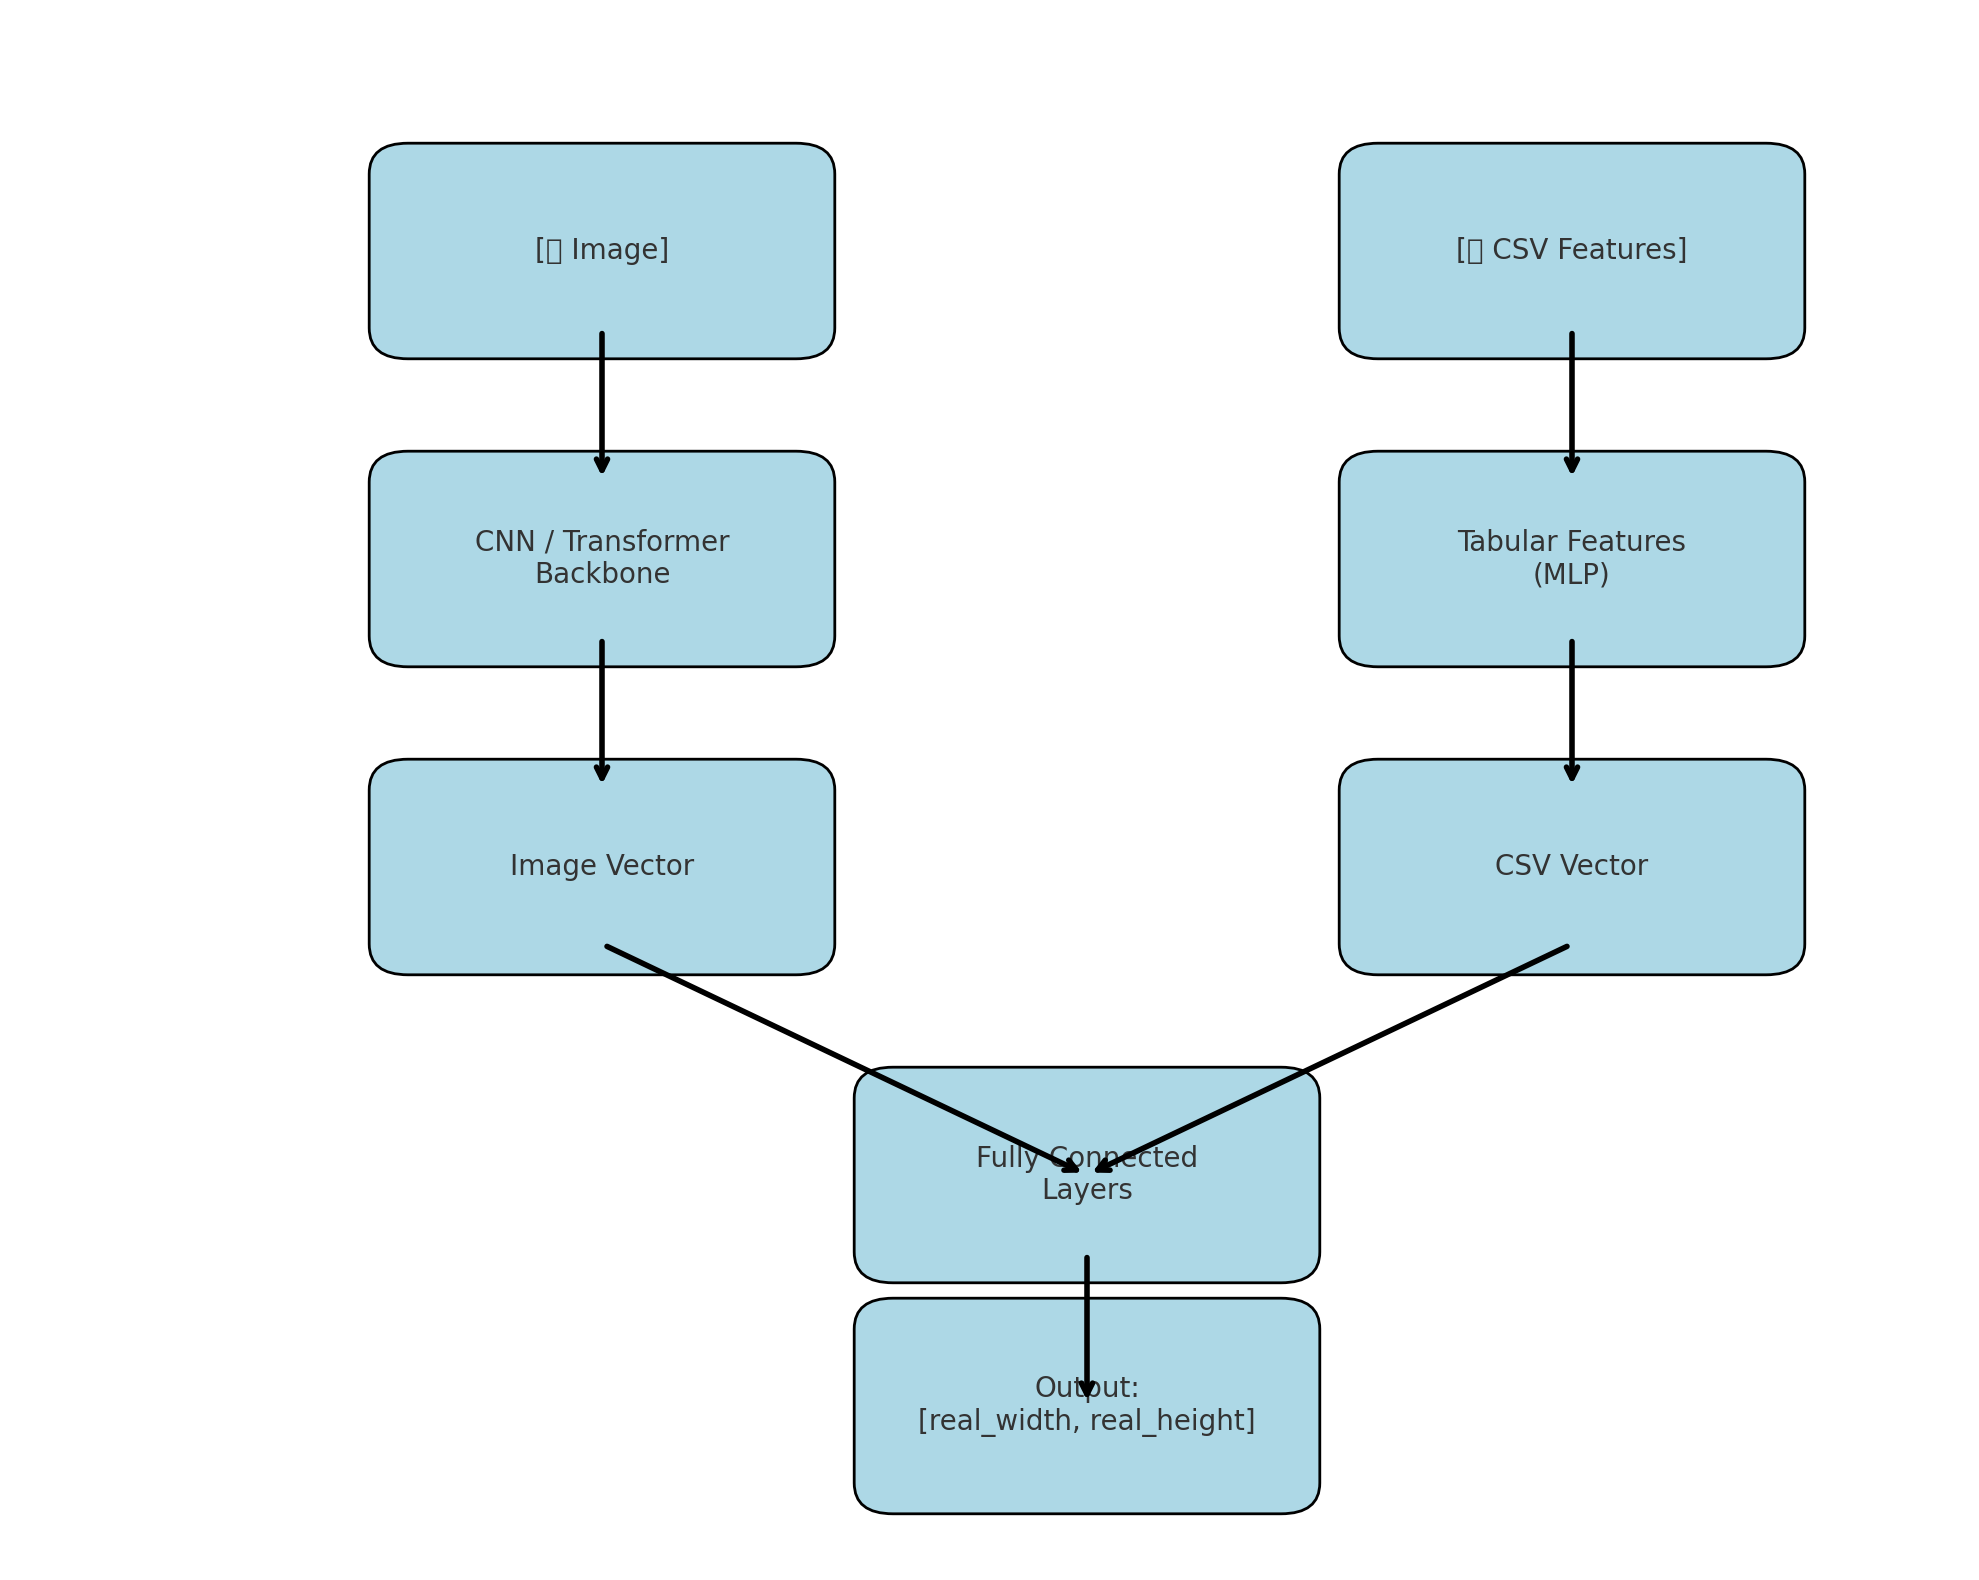

            [Image]            [CSV features]
               │                     │
        CNN/ transoformer
            backbone          Tabular Features (MLP)
               │                     │
          Image Vector          CSV Vector
               └──────────────┬───────────────┘
                              │
                    Fully Connected Layers
                              │
                 Output: [real_width, real_height]


## 🤖 Models I Will Use

I will experiment with the following **backbone architectures** to extract deep visual features:

- 🌀 **Swin Transformer**
- 🦾 **ResNet50**
- ⚡ **EfficientNetB3**
- 🔷 **ConvNeXt Base**

Each of these models will be **fine-tuned** to capture rich image representations. Their output will be **combined with tabular features** from the CSV data to enhance the overall prediction performance.

In [ ]:
from torch.utils.data import Dataset
import glob

class ImageCSVRegressionDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.df = csv_file
        self.image_dir = image_dir
        self.transform = transform
        
        # Drop target columns to use as CSV features
        self.csv_features = self.df.drop(['real_width', 'real_height'], axis=1)
        
        # Extract labels
        self.labels = self.df[['real_width', 'real_height']].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image
        img_id = str(int(self.df.iloc[idx]['image_id']))
        all_files = os.listdir(self.image_dir)
        matched_files = [f for f in all_files if f.endswith(f"{img_id}.jpg")]
        if not matched_files:
            raise FileNotFoundError(f"No image found containing ID {img_id} in {self.image_dir}")
            
        img_path = os.path.join(self.image_dir, matched_files[0])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        # CSV features (without image_id, remove targets too)
        csv_row = self.csv_features.iloc[idx]
        
        # Optionally drop columns you don't need like image_id, image_width/height
        csv_row = csv_row.drop(['image_id'])  # Drop more if needed
        
        csv_tensor = torch.tensor(csv_row.values, dtype=torch.float32)
        
        # Labels
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return image, csv_tensor, label


In [ ]:
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
class SwinCSVRegressor(nn.Module):
    def __init__(self, num_csv_features):
        super(SwinCSVRegressor, self).__init__()
        
        # Swin Transformer backbone
        self.swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)

        swin_out_dim = self.swin.num_features # will be 768

        # CSV MLP
        self.csv_mlp = nn.Sequential(
            nn.Linear(num_csv_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            #nn.ReLU(), 
        )

        # Combined regressor
        self.regressor = nn.Sequential(
            nn.Linear(swin_out_dim + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # Output: [real_width, real_height]
            #nn.ReLU()  #  This ensures output >= 0
        )

    def forward(self, image, csv_features):
        img_features = self.swin(image)  # shape: [batch_size, 768]
        
        if len(img_features.shape) == 4:
            img_features = img_features.mean(dim=[2, 3])
        csv_features = self.csv_mlp(csv_features)
        combined = torch.cat((img_features, csv_features), dim=1)
        output = self.regressor(combined)
        return output

In [ ]:
from torch.utils.data import DataLoader

TARGET_SCALE = 180.0 

df_cropped_csv_scaled['real_width'] = df_cropped_csv_scaled['real_width'] / TARGET_SCALE
df_cropped_csv_scaled['real_height'] = df_cropped_csv_scaled['real_height'] / TARGET_SCALE

csv_file =  df_cropped_csv_scaled


image_dir = '/kaggle/input/cropped-images-file'

dataset = ImageCSVRegressionDataset(
    csv_file=csv_file,
    image_dir=image_dir,
    transform=transform #this only applies to images
)

num_csv_features = dataset.csv_features.drop(['image_id'], axis=1).shape[1]

#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_cropped_csv_scaled, test_size=0.2, random_state=42)

# Train dataset
train_dataset = ImageCSVRegressionDataset(
    csv_file=train_df,
    image_dir=image_dir,
    transform=transform
)

# Test dataset (transform aynısı olabilir)
test_dataset = ImageCSVRegressionDataset(
    csv_file=test_df,
    image_dir=image_dir,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 🌀 **Swin Transformer**

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinCSVRegressor(num_csv_features=num_csv_features).to(device)
# Swin model freeze :
for param in model.swin.parameters():
    param.requires_grad = False


criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_and_validate(model, 
                       train_loader, 
                       test_loader, 
                       optimizer, 
                       criterion, 
                       mae_criterion, 
                       device, 
                       epochs=50, 
                       patience=3, 
                       target_scale=1.0,
                       save_path_prefix="best_model"):
    
    best_cm_error = float('inf')
    trigger_times = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        
        for images, csv_feats, targets in train_loader:
            images = images.to(device)
            csv_feats = csv_feats.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, csv_feats)
                
            loss = criterion(outputs, targets)
            mae = mae_criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            running_mae += mae.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_mae = running_mae / len(train_loader.dataset)
        epoch_cm_error = epoch_mae * target_scale
        
        print(f"\n Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {epoch_loss:.4f}, Avg CM Error: {epoch_cm_error:.2f} cm")

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        with torch.no_grad():
            for images, csv_feats, targets in test_loader:
                images = images.to(device)
                csv_feats = csv_feats.to(device)
                targets = targets.to(device)
                
                outputs = model(images, csv_feats)
                
                loss = criterion(outputs, targets)
                mae = mae_criterion(outputs, targets)
                
                val_loss += loss.item() * images.size(0)
                val_mae += mae.item() * images.size(0)

        val_loss /= len(test_loader.dataset)
        val_mae /= len(test_loader.dataset)
        val_cm_error = val_mae * target_scale
        
        print(f" Validation Loss: {val_loss:.4f}, Avg CM Error: {val_cm_error:.2f} cm")

        # --- Early Stopping ---
        if val_cm_error  < best_cm_error:
            best_cm_error = val_cm_error
            trigger_times = 0
            model_path = f"{save_path_prefix}_epoch{epoch+1:02d}_valCMErr{val_cm_error:.2f}.pth"
            torch.save(model.state_dict(), model_path)
            print(f" New best model saved to: {model_path}")
        else:
            trigger_times += 1
            print(f" No improvement: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print(" Early stopping triggered!")
                break

        torch.cuda.empty_cache()


#### with freeze
##### Epoch 10/50, Loss: 0.0064, Avg CM Error: 9.73 cm
##### Validation Loss: 0.0071, Validation Avg CM Error: 8.19 cm
#####  New best model saved.
#### without freeze

##### Epoch 7/50, Loss: 0.0049, Avg CM Error: 6.24 cm
##### Validation Loss: 0.0062, Validation Avg CM Error: 7.34 cm
#####  New best model saved.


# CNN
## 🦾 **ResNet50**
## ⚡ **EfficientNetB3**
## 🔷 **ConvNeXt Base**

In [ ]:
class CNNCSVRegressor(nn.Module):
    def __init__(self, num_csv_features):
        super(CNNCSVRegressor, self).__init__()
        
        # CNN backbone
        #self.cnn = timm.create_model('convnext_base', pretrained=True, num_classes=0)
        #self.cnn = timm.create_model('resnet50', pretrained=True, num_classes=0)
        self.cnn = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)

        cnn_out_dim = self.cnn.num_features 

        # CSV MLP
        self.csv_mlp = nn.Sequential(
            nn.Linear(num_csv_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )

        # Combined regressor
        self.regressor = nn.Sequential(
            nn.Linear(cnn_out_dim + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # Output: [real_width, real_height]
        )

    def forward(self, image, csv_features):
        img_features = self.cnn(image)  # ResNet otomatik flatten yapar

        csv_features = self.csv_mlp(csv_features)
        combined = torch.cat((img_features, csv_features), dim=1)
        output = self.regressor(combined)
        return output


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNCSVRegressor(num_csv_features=num_csv_features).to(device)

for param in model.cnn.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [ ]:
criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

train_and_validate(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    mae_criterion=mae_criterion,
    device=device,
    epochs=50,
    patience=3,
    target_scale=180.0
)


## efficientnet_b3

#### with freeze
##### Epoch 2/50, Loss: 0.0077, Avg CM Error: 9.73 cm
##### Validation Loss: 0.0085, Validation Avg CM Error: 10.19 cm
#####  New best model saved.
#### without freeze

##### Epoch 2/50, Loss: 0.0055, Avg CM Error: 8.24 cm
##### Validation Loss: 0.0074, Validation Avg CM Error: 9.34 cm
#####  New best model saved.


## ResNet50

#### with freeze:

##### Epoch 8/50, Loss: 0.0069, Avg CM Error: 9.49 cm
##### Validation Loss: 0.0081, Validation Avg CM Error: 9.99 cm
#####  New best model saved.

#### without freeze
##### Epoch 3/50, Loss: 0.0049, Avg CM Error: 8.10 cm
##### Validation Loss: 0.0065
#####  New best model saved.


In [ ]:
#from torchvision.models import swin_t
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinCSVRegressor(num_csv_features=num_csv_features).to(device)
model.load_state_dict(torch.load("/kaggle/input/swintransformer_freezen/pytorch/default/1/best_model_swinTransformer.pth"))


for param in model.swin.parameters():
    param.requires_grad = True


optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)



In [ ]:
criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

train_and_validate(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    mae_criterion=mae_criterion,
    device=device,
    epochs=50,
    patience=8,
    target_scale=180.0
)


## Kernel was closed because I coincided with the Kaggle weekly GPU refresh

# Test

In [ ]:
def test_model(model, test_loader, criterion, mae_criterion, device, target_scale=1.0):
    model.eval()
    test_loss = 0.0
    test_mae = 0.0

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for images, csv_feats, targets in test_loader:
            images = images.to(device)
            csv_feats = csv_feats.to(device)
            targets = targets.to(device)

            outputs = model(images, csv_feats)
            outputs = torch.abs(outputs)

            loss = criterion(outputs, targets)
            mae = mae_criterion(outputs, targets)

            test_loss += loss.item() * images.size(0)
            test_mae += mae.item() * images.size(0)

            all_targets.append(targets.cpu())
            all_predictions.append(outputs.cpu())

    test_loss /= len(test_loader.dataset)
    test_mae /= len(test_loader.dataset)
    test_cm_error = test_mae * target_scale

    print(f"\nTest Loss: {test_loss:.4f}, Avg CM Error: {test_cm_error:.2f} cm")

    return torch.cat(all_targets), torch.cat(all_predictions)


In [ ]:
#from torchvision.models import swin_t
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = SwinCSVRegressor(num_csv_features=num_csv_features).to(device)
best_model.load_state_dict(torch.load("/kaggle/input/best_model/pytorch/default/1/best_model_epoch34_valCMErr7.62.pth"))
best_model.to(device)

In [ ]:
mae_criterion = nn.L1Loss()
targets, predictions = test_model(best_model, test_loader, criterion, mae_criterion, device, target_scale=180.0)

In [ ]:
import numpy as np

# Test loader'dan bir batch çekelim (genelde batch size 1 ayarla istersen)
sample = next(iter(test_loader))
images, csv_feats, targets = sample

images = images.to(device)
csv_feats = csv_feats.to(device)
targets = targets.to(device)

model.eval()
with torch.no_grad():
    output = best_model(images, csv_feats)
    output = torch.abs(output)

output = output.cpu().numpy()
targets = targets.cpu().numpy()

# CM cinsinden değerler
targets_cm = targets * 180
output_cm = output * 180

# Hata hesaplama (mutlak hata)
cm_error = np.abs(targets_cm - output_cm)

print(f"Gerçek Değer (cm): {targets_cm}")
print(f"Tahmin (cm): {output_cm}")
print(f"Hata (cm): {cm_error}")

# İstersen toplam MAE de yazdırabilirsin (bu sadece 1 örnek için, batch size > 1 olursa ortalama alınır)
mean_cm_error = np.mean(cm_error)
print(f"Ortalama Hata (cm): {mean_cm_error:.2f} cm")
